In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import h5py
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras import layers, models, optimizers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler

# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils

In [ ]:
def check_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
        except RuntimeError as e:
            print(e)
    return len(gpus) > 0



In [5]:
# electron_path = 'SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
# photon_path = 'SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
electron_path = '/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
photon_path = '/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'


In [6]:
with h5py.File(electron_path, 'r') as f:
    print("Electron file structure:")
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):  # If item is a dataset
            print(f"- Dataset: {key}, Shape: {item.shape}, Dtype: {item.dtype}")


Electron file structure:
- Dataset: X, Shape: (249000, 32, 32, 2), Dtype: float32
- Dataset: y, Shape: (249000,), Dtype: float32


In [7]:
with h5py.File(photon_path, 'r') as f:
    print("Photon file structure:")
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):  # If item is a dataset
            print(f"- Dataset: {key}, Shape: {item.shape}, Dtype: {item.dtype}")


Photon file structure:
- Dataset: X, Shape: (249000, 32, 32, 2), Dtype: float32
- Dataset: y, Shape: (249000,), Dtype: float32


In [ ]:
# electron_path = h5py.File('/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5')
# photon_path = h5py.File('/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5')

In [8]:
def print_hdf5_structure(f, indent=0):
    """Helper function to print HDF5 file structure"""
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):  # If item is a dataset
            print(" " * indent + f"- Dataset: {key}, Shape: {item.shape}, Dtype: {item.dtype}")
        elif isinstance(item, h5py.Group):  # If item is a group
            print(" " * indent + f"- Group: {key}")
            print_hdf5_structure(item, indent + 2)


In [9]:

def normalize_data(data):
    """Min-max normalization for each sample"""
    result = np.zeros_like(data, dtype=np.float32)
    for i in range(len(data)):
        min_val = np.min(data[i])
        max_val = np.max(data[i])
        if max_val > min_val:
            result[i] = (data[i] - min_val) / (max_val - min_val)
        # If all values are the same, leave as zeros
    return result


In [ ]:

# Load and preprocess the data
def data_structure(electron_file, photon_file):
    """
    Load electron and photon data from HDF5 files.

    Args:
        electron_file (str): Path to electron data file
        photon_file (str): Path to photon data file

    Returns:
        tuple: (X_train, y_train, X_test, y_test)
    """
    # Load electron data (class 0)
    with h5py.File(electron_file, 'r') as f:
        print("Electron file structure:")
        print_hdf5_structure(f)
        try:
            # First attempt with expected names
            electron_energy = np.array(f['energy'])
            electron_time = np.array(f['time'])
        except KeyError:
            # If those keys don't exist, look for other possible structures
            if 'X' in f:
                # If data is stored as a single dataset with multiple channels
                data = np.array(f['X'])
                print(f"Found data with shape: {data.shape}")

                # Assuming data shape is (n_samples, 2, 32, 32) or (n_samples, 32, 32, 2)
                if len(data.shape) == 4:
                    if data.shape[1] == 2:  # (n_samples, 2, height, width)
                        electron_energy = data[:, 0]
                        electron_time = data[:, 1]
                    elif data.shape[3] == 2:  # (n_samples, height, width, 2)
                        electron_energy = data[..., 0]
                        electron_time = data[..., 1]
                    else:
                        raise ValueError(f"Unexpected data shape: {data.shape}")
                else:
                    raise ValueError(f"Unexpected data dimensions: {len(data.shape)}")
            else:
                # List all available keys and try to infer which ones contain the data
                print("Available keys in electron file:", list(f.keys()))
                raise KeyError("Could not find expected data structure in electron file")

    # Load photon data (class 1)
    with h5py.File(photon_file, 'r') as f:
        print("Photon file structure:")
        print_hdf5_structure(f)
        try:
            photon_energy = np.array(f['energy'])
            photon_time = np.array(f['time'])
        except KeyError:
            # If those keys don't exist, look for other possible structures
            if 'X' in f:
                data = np.array(f['X'])
                print(f"Found data with shape: {data.shape}")

                if len(data.shape) == 4:
                    if data.shape[1] == 2:  # (n_samples, 2, height, width)
                        photon_energy = data[:, 0]
                        photon_time = data[:, 1]
                    elif data.shape[3] == 2:  # (n_samples, height, width, 2)
                        photon_energy = data[..., 0]
                        photon_time = data[..., 1]
                    else:
                        raise ValueError(f"Unexpected data shape: {data.shape}")
                else:
                    raise ValueError(f"Unexpected data dimensions: {len(data.shape)}")
            else:
                print("Available keys in photon file:", list(f.keys()))
                raise KeyError("Could not find expected data structure in photon file")

    # Print shapes to verify data loading
    print(f"Electron energy shape: {electron_energy.shape}")
    print(f"Electron time shape: {electron_time.shape}")
    print(f"Photon energy shape: {photon_energy.shape}")
    print(f"Photon time shape: {photon_time.shape}")


In [ ]:
# data_structure(electron_path, photon_path)

Dataset 'X' shape: (249000, 32, 32, 2)


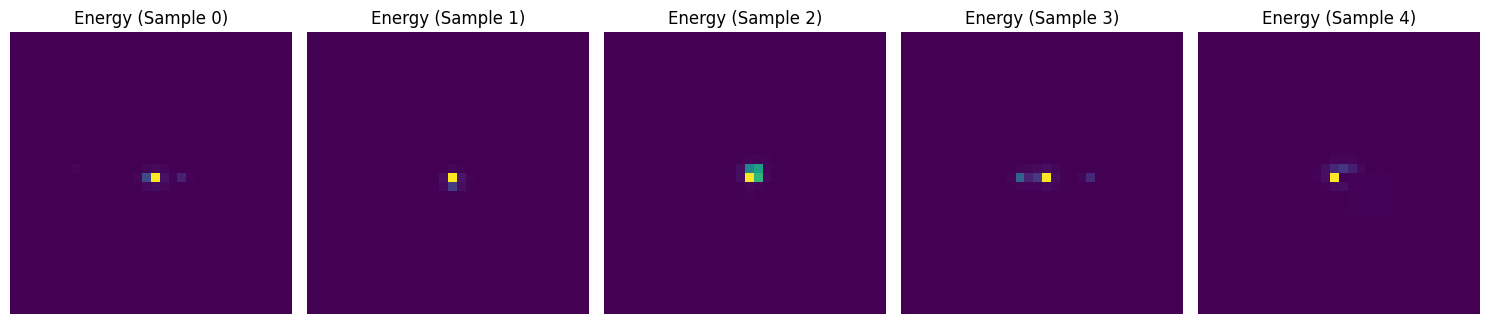

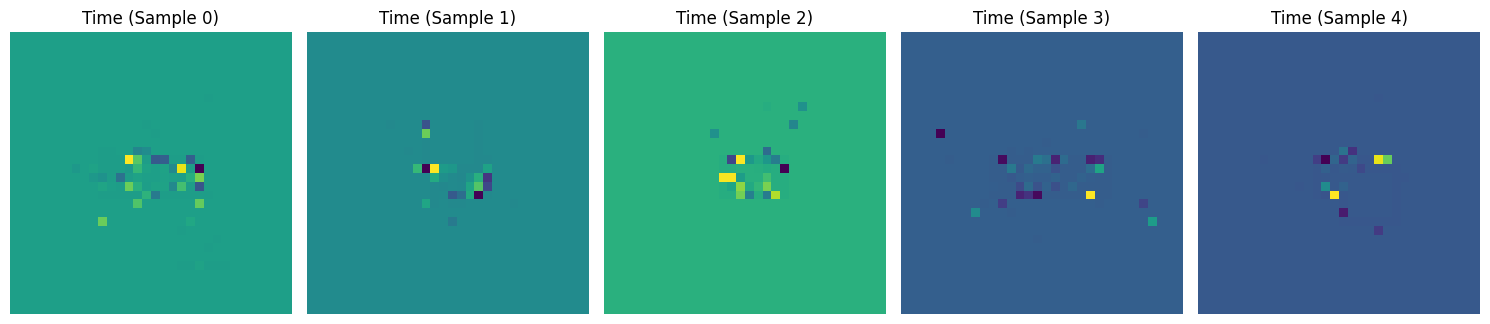

Dataset 'X' shape: (249000, 32, 32, 2)


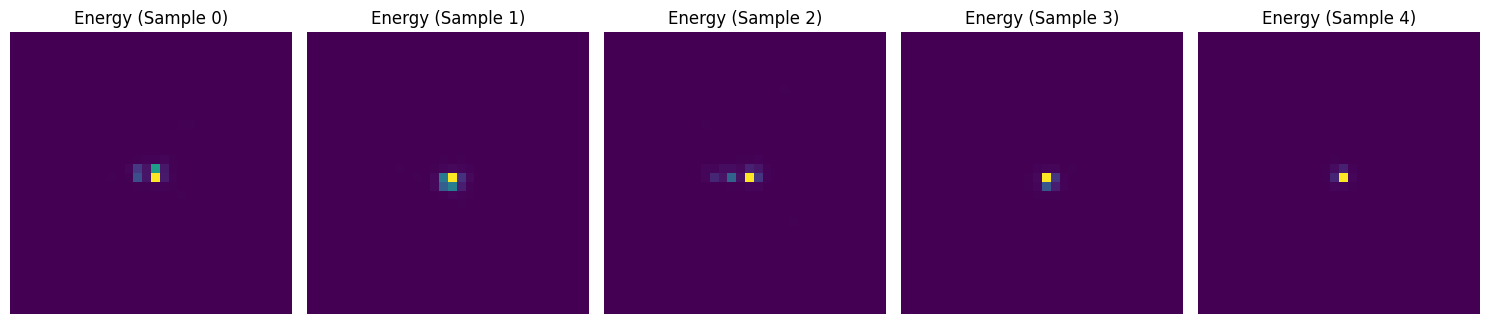

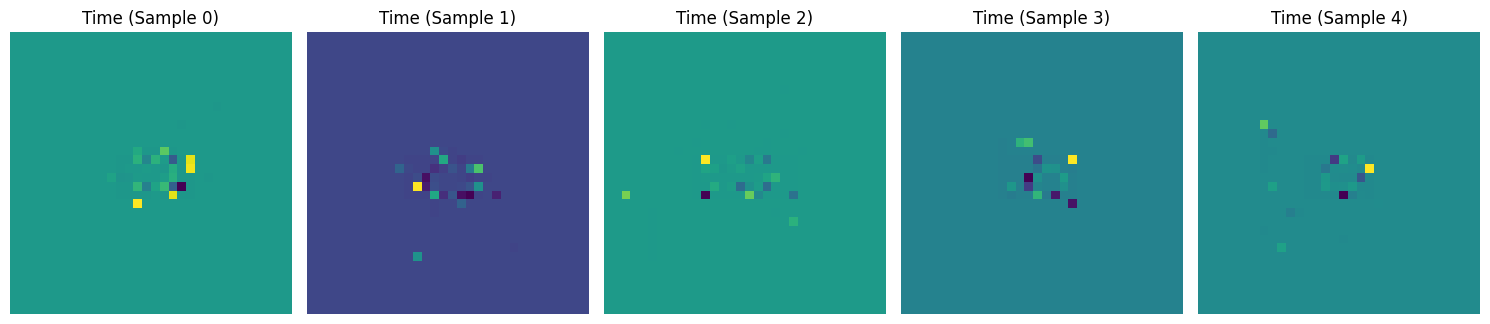

In [11]:
def visualize_data(file_path, dataset_name='X', num_images=5):
    """
    Visualizes a specified dataset from an HDF5 file.

    Args:
        file_path (str): Path to the HDF5 file.
        dataset_name (str): Name of the dataset to visualize.
        num_images (int): Number of images to display.
    """

    with h5py.File(file_path, 'r') as f:
        if dataset_name in f:
            data = np.array(f[dataset_name])
            print(f"Dataset '{dataset_name}' shape: {data.shape}")

            if len(data.shape) == 4 and data.shape[1] == 2:
                fig, axes = plt.subplots(1, min(num_images, data.shape[0]), figsize=(15, 5))
                for i in range(min(num_images, data.shape[0])):
                    energy = data[i, 0]
                    time = data[i, 1]
                    axes[i].imshow(energy, cmap='viridis')
                    axes[i].set_title(f'Energy (Sample {i})')
                    axes[i].axis('off')
                plt.tight_layout()
                plt.show()

                fig, axes = plt.subplots(1, min(num_images, data.shape[0]), figsize=(15, 5))
                for i in range(min(num_images, data.shape[0])):
                    energy = data[i, 0]
                    time = data[i, 1]
                    axes[i].imshow(time, cmap='viridis')
                    axes[i].set_title(f'Time (Sample {i})')
                    axes[i].axis('off')
                plt.tight_layout()
                plt.show()


            elif len(data.shape) == 4 and data.shape[3] == 2:
                fig, axes = plt.subplots(1, min(num_images, data.shape[0]), figsize=(15, 5))
                for i in range(min(num_images, data.shape[0])):
                    energy = data[i, :, :, 0]
                    time = data[i, :, :, 1]
                    axes[i].imshow(energy, cmap='viridis')
                    axes[i].set_title(f'Energy (Sample {i})')
                    axes[i].axis('off')
                plt.tight_layout()
                plt.show()

                fig, axes = plt.subplots(1, min(num_images, data.shape[0]), figsize=(15, 5))
                for i in range(min(num_images, data.shape[0])):
                    energy = data[i, :, :, 0]
                    time = data[i, :, :, 1]
                    axes[i].imshow(time, cmap='viridis')
                    axes[i].set_title(f'Time (Sample {i})')
                    axes[i].axis('off')
                plt.tight_layout()
                plt.show()

            else:
                print(f"Dataset '{dataset_name}' has an unsupported shape for visualization.")
        else:
            print(f"Dataset '{dataset_name}' not found in the file.")

visualize_data(electron_path)

visualize_data(photon_path)


Since there was problem while converting these images into array so I used 70% of the given data as 100% and then built the model

In [ ]:
def load_particle_data(electron_file, photon_file,data_fraction=0.7, batch_processing=True):
    """
    Load electron and photon data from HDF5 files.

    Args:
        electron_file (str): Path to electron data file
        photon_file (str): Path to photon data file
        batch_processing (bool): Whether to process data in batches to save memory
        max_samples (int, optional): Maximum number of samples to load from each class

    Returns:
        tuple: (X_train, y_train, X_test, y_test)
    """
    # Load electron data (class 0)
    with h5py.File(electron_file, 'r') as f:
        print("Electron file structure:")
        print_hdf5_structure(f)
        try:
            # First attempt with expected names
            electron_energy = np.array(f['energy'])
            electron_time = np.array(f['time'])
        except KeyError:
            # If those keys don't exist, look for other possible structures
            if 'X' in f:
                # If data is stored as a single dataset with multiple channels
                data = np.array(f['X'])
                print(f"Found data with shape: {data.shape}")

                if len(data.shape) == 4:
                    if data.shape[1] == 2:  # (n_samples, 2, height, width)
                        electron_energy = data[:, 0]
                        electron_time = data[:, 1]
                    elif data.shape[3] == 2:  # (n_samples, height, width, 2)
                        electron_energy = data[..., 0]
                        electron_time = data[..., 1]
                    else:
                        raise ValueError(f"Unexpected data shape: {data.shape}")
                else:
                    raise ValueError(f"Unexpected data dimensions: {len(data.shape)}")
            else:
                # List all available keys and try to infer which ones contain the data
                print("Available keys in electron file:", list(f.keys()))
                raise KeyError("Could not find expected data structure in electron file")

    # Load photon data (class 1)
    with h5py.File(photon_file, 'r') as f:
        print("Photon file structure:")
        print_hdf5_structure(f)
        try:
            photon_energy = np.array(f['energy'])
            photon_time = np.array(f['time'])
        except KeyError:
            # If those keys don't exist, look for other possible structures
            if 'X' in f:
                data = np.array(f['X'])
                print(f"Found data with shape: {data.shape}")

                if len(data.shape) == 4:
                    if data.shape[1] == 2:  # (n_samples, 2, height, width)
                        photon_energy = data[:, 0]
                        photon_time = data[:, 1]
                    elif data.shape[3] == 2:  # (n_samples, height, width, 2)
                        photon_energy = data[..., 0]
                        photon_time = data[..., 1]
                    else:
                        raise ValueError(f"Unexpected data shape: {data.shape}")
                else:
                    raise ValueError(f"Unexpected data dimensions: {len(data.shape)}")
            else:
                print("Available keys in photon file:", list(f.keys()))
                raise KeyError("Could not find expected data structure in photon file")

    #Applying data fraction reduction
    electron_total = len(electron_energy)
    photon_total = len(photon_energy)

    #Using data fraction
    electron_samples = int(electron_total * data_fraction)
    photon_samples = int(photon_total * data_fraction)

    #Shuffle indices before selecting subset to ensure randomness
    np.random.seed(42)
    electron_indices = np.random.permutation(electron_total)[:electron_samples]
    photon_indices = np.random.permutation(photon_total)[:photon_samples]

    electron_energy = electron_energy[electron_indices]
    electron_time = electron_time[electron_indices]
    photon_energy = photon_energy[photon_indices]
    photon_time = photon_time[photon_indices]


    # Print shapes to verify data loading
    print(f"Using {data_fraction*100:.1f}% of original data")
    print(f"Electron energy shape: {electron_energy.shape}")
    print(f"Electron time shape: {electron_time.shape}")
    print(f"Photon energy shape: {photon_energy.shape}")
    print(f"Photon time shape: {photon_time.shape}")

    # Create labels
    electron_labels = np.zeros(len(electron_energy))
    photon_labels = np.ones(len(photon_energy))

    if batch_processing:
        # Process in memory-efficient batches
        return _process_in_batches(electron_energy, electron_time, electron_labels,photon_energy, photon_time, photon_labels)
    else:
        # Combine data
        energy = np.vstack((electron_energy, photon_energy))
        time = np.vstack((electron_time, photon_time))
        labels = np.hstack((electron_labels, photon_labels))

        # Normalize data
        energy = normalize_data(energy)
        time = normalize_data(time)

        # Stack channels to create 2-channel images
        # Format: (samples, height, width, channels)
        images = np.stack([energy, time], axis=-1)

        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            images, labels, test_size=0.2, random_state=42
        )

        print(f"Dataset loaded: {len(labels)} samples")
        print(f"Class distribution: {np.sum(labels == 0)} electrons, {np.sum(labels == 1)} photons")
        print(f"Training set size: {len(X_train)}")
        print(f"Test set size: {len(X_test)}")

        return X_train, y_train, X_test, y_test

def _process_in_batches(electron_energy, electron_time, electron_labels, photon_energy, photon_time, photon_labels, batch_size=4000):
    """
    Process data in batches to avoid memory issues.

    Args:
        electron_energy, electron_time: Electron data arrays
        electron_labels: Labels for electron data
        photon_energy, photon_time: Photon data arrays
        photon_labels: Labels for photon data
        batch_size: Number of samples to process at once

    Returns:
        X_train, y_train, X_test, y_test: Train/test split data
    """
    # Initialize empty lists for train/test data
    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    # Set random seed for consistent splits
    np.random.seed(42)

    # Calculate total samples
    total_electron = len(electron_energy)
    total_photon = len(photon_energy)
    total_samples = total_electron + total_photon

    print(f"Processing {total_samples} samples in batches of {batch_size}")

    # Process electron data in batches
    for start_idx in range(0, total_electron, batch_size):
        end_idx = min(start_idx + batch_size, total_electron)
        batch_size_actual = end_idx - start_idx

        # Get batch data
        e_energy_batch = normalize_data(electron_energy[start_idx:end_idx])
        e_time_batch = normalize_data(electron_time[start_idx:end_idx])
        e_labels_batch = electron_labels[start_idx:end_idx]

        # Stack channels
        e_images_batch = np.stack([e_energy_batch, e_time_batch], axis=-1)

        # Determine train/test split (80/20)
        split_idx = int(0.8 * batch_size_actual)
        indices = np.random.permutation(batch_size_actual)
        train_idx, test_idx = indices[:split_idx], indices[split_idx:]

        # Add to train/test lists
        X_train_list.append(e_images_batch[train_idx])
        X_test_list.append(e_images_batch[test_idx])
        y_train_list.append(e_labels_batch[train_idx])
        y_test_list.append(e_labels_batch[test_idx])

        print(f"Processed electron batch {start_idx//batch_size + 1}/{(total_electron-1)//batch_size + 1}")

    # Process photon data in batches
    for start_idx in range(0, total_photon, batch_size):
        end_idx = min(start_idx + batch_size, total_photon)
        batch_size_actual = end_idx - start_idx

        # Get batch data
        p_energy_batch = normalize_data(photon_energy[start_idx:end_idx])
        p_time_batch = normalize_data(photon_time[start_idx:end_idx])
        p_labels_batch = photon_labels[start_idx:end_idx]

        # Stack channels
        p_images_batch = np.stack([p_energy_batch, p_time_batch], axis=-1)

        # Determine train/test split (80/20)
        split_idx = int(0.8 * batch_size_actual)
        indices = np.random.permutation(batch_size_actual)
        train_idx, test_idx = indices[:split_idx], indices[split_idx:]

        # Add to train/test lists
        X_train_list.append(p_images_batch[train_idx])
        X_test_list.append(p_images_batch[test_idx])
        y_train_list.append(p_labels_batch[train_idx])
        y_test_list.append(p_labels_batch[test_idx])

        print(f"Processed photon batch {start_idx//batch_size + 1}/{(total_photon-1)//batch_size + 1}")

    # Concatenate results
    X_train = np.concatenate(X_train_list)
    X_test = np.concatenate(X_test_list)
    y_train = np.concatenate(y_train_list)
    y_test = np.concatenate(y_test_list)


    print(f"Dataset loaded: {total_samples} samples")
    print(f"Class distribution: {total_electron} electrons, {total_photon} photons")
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    return X_train, y_train, X_test, y_test

In [14]:
X_train, y_train, X_test, y_test = load_particle_data(electron_path, photon_path)


Electron file structure:
- Dataset: X, Shape: (249000, 32, 32, 2), Dtype: float32
- Dataset: y, Shape: (249000,), Dtype: float32
Found data with shape: (249000, 32, 32, 2)
Photon file structure:
- Dataset: X, Shape: (249000, 32, 32, 2), Dtype: float32
- Dataset: y, Shape: (249000,), Dtype: float32
Found data with shape: (249000, 32, 32, 2)
Using 70.0% of original data
Electron energy shape: (174300, 32, 32)
Electron time shape: (174300, 32, 32)
Photon energy shape: (174300, 32, 32)
Photon time shape: (174300, 32, 32)
Processing 348600 samples in batches of 4000
Processed electron batch 1/44
Processed electron batch 2/44
Processed electron batch 3/44
Processed electron batch 4/44
Processed electron batch 5/44
Processed electron batch 6/44
Processed electron batch 7/44
Processed electron batch 8/44
Processed electron batch 9/44
Processed electron batch 10/44
Processed electron batch 11/44
Processed electron batch 12/44
Processed electron batch 13/44
Processed electron batch 14/44
Process

In [15]:
X_train.shape, y_train.shape

((278880, 32, 32, 2), (278880,))

In [16]:
X_test.shape, y_test.shape

((69720, 32, 32, 2), (69720,))

In [17]:
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_test dtype:", y_test.dtype)


X_train dtype: float32
y_train dtype: float64
X_test dtype: float32
y_test dtype: float64


In [18]:
y_train = y_train.astype("int32")
y_test = y_test.astype("int32")


In [19]:
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_test dtype:", y_test.dtype)


X_train dtype: float32
y_train dtype: int32
X_test dtype: float32
y_test dtype: int32


In [20]:
print("NaN in X_train:", np.isnan(X_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())


NaN in X_train: 0
Inf in X_train: 0


In [21]:
len(X_train)

278880

In [22]:
# Basic Block function for ResNet
def basic_block(x, filters, stride=1, name=None):
    """
    Create a basic ResNet block with two conv layers and a skip connection.

    Args:
        x: Input tensor
        filters: Number of filters for the convolutional layers
        stride: Stride for the first convolutional layer
        name: Prefix for the layers' names

    Returns:
        Output tensor after applying the basic block
    """
    if name is None:
        name = 'basic_block'

    # First convolution
    conv1 = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same',use_bias=False, name=f'{name}_conv1')(x)
    bn1 = layers.BatchNormalization(name=f'{name}_bn1')(conv1)
    relu1 = layers.ReLU(name=f'{name}_relu1')(bn1)

    # Second convolution
    conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False, name=f'{name}_conv2')(relu1)
    bn2 = layers.BatchNormalization(name=f'{name}_bn2')(conv2)

    # Skip connection (shortcut)
    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride,use_bias=False, name=f'{name}_shortcut_conv')(x)
        shortcut = layers.BatchNormalization(name=f'{name}_shortcut_bn')(shortcut)
    else:
        shortcut = x

    # Add skip connection and apply ReLU
    out = layers.add([bn2, shortcut], name=f'{name}_add')
    out = layers.ReLU(name=f'{name}_relu2')(out)

    return out

# Create a layer of basic blocks
def resnet_layer(x, blocks, filters, stride=1, name=None):
    """
    Create a layer of multiple basic blocks.

    Args:
        x: Input tensor
        blocks: Number of basic blocks in the layer
        filters: Number of filters for the convolutional layers
        stride: Stride for the first block in the layer
        name: Prefix for the layer's name

    Returns:
        Output tensor after applying the layer
    """
    if name is None:
        name = 'layer'

    # First block may have a stride != 1
    x = basic_block(x, filters, stride=stride, name=f'{name}_block1')

    # Remaining blocks maintain dimensions
    for i in range(1, blocks):
        x = basic_block(x, filters, stride=1, name=f'{name}_block{i+1}')

    return x

# Build the ResNet-15 model
def build_resnet15(input_shape=(32, 32, 2), num_classes=2):
    """
    Build a ResNet-15 model for image classification.

    Args:
        input_shape: Shape of the input images (height, width, channels)
        num_classes: Number of output classes

    Returns:
        A Keras Model
    """
    inputs = layers.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same',use_bias=False, name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)

    # Create ResNet layers
    x = resnet_layer(x, blocks=3, filters=64, stride=1, name='layer1')
    x = resnet_layer(x, blocks=4, filters=128, stride=2, name='layer2')
    x = resnet_layer(x, blocks=6, filters=256, stride=2, name='layer3')

    # Global Average Pooling and final fully connected layer
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name='ResNet15')

    return model

In [23]:
input_shape = X_train.shape[1:]  # (height, width, channels)
model = build_resnet15(input_shape = input_shape)

In [24]:
model.summary()

Model: "ResNet15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 2)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 32, 32, 128)    │          2,304 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1 (BatchNormalization)  │ (None, 32, 32, 128)    │            512 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu1 (ReLU)              │ (None, 32, 32, 128)    │              0 │ bn1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block1_conv1       │ (None, 32, 32, 64)     │         73,728 │ relu1[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block1_bn1         │ (None, 32, 32, 64)     │            256 │ layer1_block1_conv1[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block1_relu1       │ (None, 32, 32, 64)     │              0 │ layer1_block1_bn1[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block1_conv2       │ (None, 32, 32, 64)     │         36,864 │ layer1_block1_relu1[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block1_shortcut_c… │ (None, 32, 32, 64)     │          8,192 │ relu1[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block1_bn2         │ (None, 32, 32, 64)     │            256 │ layer1_block1_conv2[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block1_shortcut_bn │ (None, 32, 32, 64)     │            256 │ layer1_block1_shortcu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block1_add (Add)   │ (None, 32, 32, 64)     │              0 │ layer1_block1_bn2[0][… │
│                           │                        │                │ layer1_block1_shortcu… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block1_relu2       │ (None, 32, 32, 64)     │              0 │ layer1_block1_add[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block2_conv1       │ (None, 32, 32, 64)     │         36,864 │ layer1_block1_relu2[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_block2_bn1    

 Total params: 8,219,138 (31.35 MB)

 Trainable params: 8,209,026 (31.31 MB)

 Non-trainable params: 10,112 (39.50 KB)

In [27]:
# Custom OneCycleLR learning rate scheduler
def one_cycle_lr_scheduler(max_lr, epochs, steps_per_epoch, pct_start=0.3, div_factor=10, final_div_factor=100):
    """
    Creates a callback for the One Cycle LR policy.

    Args:
        max_lr: Maximum learning rate
        epochs: Total number of epochs
        steps_per_epoch: Number of steps per epoch
        pct_start: Percentage of iterations for learning rate warmup
        div_factor: Initial learning rate is max_lr/div_factor
        final_div_factor: Final learning rate is max_lr/(div_factor*final_div_factor)

    Returns:
        A callback that adjusts the learning rate
    """
    total_steps = epochs * steps_per_epoch
    warmup_steps = int(total_steps * pct_start)
    cooldown_steps = total_steps - warmup_steps

    initial_lr = max_lr / div_factor
    final_lr = max_lr / (div_factor * final_div_factor)

    def lr_schedule(epoch, lr):
        # Convert epoch to step
        step = epoch * steps_per_epoch

        if step < warmup_steps:
            # Linear increase from initial_lr to max_lr
            return initial_lr + (max_lr - initial_lr) * step / warmup_steps
        else:
            # Cosine annealing from max_lr to final_lr
            x = (step - warmup_steps) / cooldown_steps
            return final_lr + 0.5 * (max_lr - final_lr) * (1 + np.cos(np.pi * x))

    return LearningRateScheduler(lr_schedule, verbose=1)



In [ ]:
from scipy.sparse import csr_matrix

# Train the model
def train_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=30):
    """
    Train the model with the provided data.

    Args:
        model: The Keras model to train
        X_train, y_train: Training data and labels
        X_test, y_test: Test data and labels
        batch_size: Batch size for training
        epochs: Number of epochs to train for

    Returns:
        Training history and the trained model
    """
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        # loss='categorical_crossentropy',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    # Calculate steps per epoch
    steps_per_epoch = len(X_train) // batch_size

    # Create callbacks
    callbacks = [
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            verbose=1,
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        one_cycle_lr_scheduler(
            max_lr=0.01,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch
        )
    ]

    # Train the model
    history = model.fit(
        X_train, y_train, #y_train_onehot
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test), #y_test_onehot
        callbacks=callbacks,
        verbose=1
    )

    # Load the best model
    model = tf.keras.models.load_model('best_model.h5')

    return history, model

In [ ]:
history, model = train_model(model, X_train, y_train, X_test, y_test, epochs=30)

# train_model(model, X_train, y_train, X_test, y_test)

In [ ]:
# Plot training history
import seaborn as sns
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy.

    Args:
        history: History object returned by model.fit()
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curves')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()



In [ ]:

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and display various metrics and visualizations.

    Args:
        model: Trained Keras model
        X_test, y_test: Test data and labels

    Returns:
        Dictionary containing evaluation metrics
    """
    # Convert labels to one-hot encoded format for evaluation
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=2)

    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)
    print(f"Final Test Accuracy: {test_acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Electron', 'Photon']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Electron', 'Photon'], yticklabels=['Electron', 'Photon'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Electron', 'Photon'], yticklabels=['Electron', 'Photon'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"ROC AUC: {roc_auc:.4f}")

    return {
        'test_accuracy': test_acc,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

In [ ]:

# Visualize sample images
def visualize_sample_images(X, y, indices=None, num_samples=5):
    """
    Visualize sample images from the dataset.

    Args:
        X: Image data (samples, height, width, channels)
        y: Labels
        indices: Specific indices to visualize (optional)
        num_samples: Number of samples to visualize if indices not provided
    """
    if indices is None:
        indices = np.random.choice(len(X), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        img = X[idx]
        label = y[idx]

        # Print image statistics
        print(f"Sample {idx} shape: {img.shape}")
        print(f"Channel 0 (Energy) - Min: {img[..., 0].min():.4f}, Max: {img[..., 0].max():.4f}, Mean: {img[..., 0].mean():.4f}")
        print(f"Channel 1 (Time) - Min: {img[..., 1].min():.4f}, Max: {img[..., 1].max():.4f}, Mean: {img[..., 1].mean():.4f}")

        # Plot energy channel
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.title(f"Class: {'Electron' if label == 0 else 'Photon'}")
        plt.imshow(img[..., 0], cmap='viridis')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        plt.title('Energy Channel')

        # Plot time channel
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(img[..., 1], cmap='plasma')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        plt.title('Time Channel')

        # Combined channels (RGB visualization)
        plt.subplot(num_samples, 3, i*3 + 3)
        # Create a 3-channel RGB image for visualization
        h, w = img.shape[:2]
        rgb_img = np.zeros((h, w, 3))
        rgb_img[..., 0] = img[..., 0]  # Energy in R channel
        rgb_img[..., 1] = img[..., 1]  # Time in G channel
        plt.imshow(rgb_img)
        plt.axis('off')
        plt.title('Combined Channels')

    plt.tight_layout()
    plt.show()


In [ ]:

# Visualize misclassified samples
def misclassified_samples(model, X_test, y_test, num_samples=5):
    """
    Visualize misclassified samples.

    Args:
        model: Trained Keras model
        X_test, y_test: Test data and labels
        num_samples: Number of misclassified samples to visualize
    """
    # Get predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Find misclassified samples
    misclassified_indices = np.where(y_pred != y_test)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified samples found!")
        return

    # Limit to requested number of samples
    indices = misclassified_indices[:num_samples]

    # Visualize the misclassified samples
    visualize_sample_images(X_test, y_test, indices, len(indices))

    # Show prediction details
    for i, idx in enumerate(indices):
        print(f"Sample {idx}:")
        print(f"  True label: {'Electron' if y_test[idx] == 0 else 'Photon'}")
        print(f"  Predicted: {'Electron' if y_pred[idx] == 0 else 'Photon'}")
        print(f"  Probabilities: Electron: {y_pred_probs[idx][0]:.4f}, Photon: {y_pred_probs[idx][1]:.4f}")
        print()

In [ ]:

# Feature importance visualization with Grad-CAM
def visualize_feature_importance(model, X_test, y_test, num_samples=5):
    """
    Visualize feature importance using Grad-CAM.

    Args:
        model: Trained Keras model
        X_test, y_test: Test data and labels
        num_samples: Number of samples to visualize
    """
    # Create a model that outputs both the predictions and the last conv layer activations
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D):
            last_conv_layer = layer.name
            break

    if last_conv_layer is None:
        print("Could not find a convolutional layer")
        return

    # Create a Grad-CAM model
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer).output, model.output]
    )

    # Select random samples
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    for idx in indices:
        img = X_test[idx]
        label = y_test[idx]
        img_array = np.expand_dims(img, axis=0)

        # Get predictions and feature map
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            class_idx = np.argmax(predictions[0])
            loss = predictions[:, class_idx]

        # Extract gradients
        grads = tape.gradient(loss, conv_outputs)

        # Global average pooling of the gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Weight feature maps with the gradients
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap = heatmap.numpy()

        # Resize heatmap to match input image size
        heatmap = np.uint8(255 * heatmap)
        heatmap = tf.image.resize(
            np.expand_dims(heatmap, axis=-1),
            (img.shape[0], img.shape[1])
        ).numpy().squeeze()

        # Visualize
        plt.figure(figsize=(15, 5))

        # Original image - energy channel
        plt.subplot(1, 3, 1)
        plt.title(f"Original - {'Electron' if label == 0 else 'Photon'}")
        plt.imshow(img[..., 0], cmap='viridis')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

        # Original image - time channel
        plt.subplot(1, 3, 2)
        plt.title("Time Channel")
        plt.imshow(img[..., 1], cmap='plasma')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

        # Heatmap
        plt.subplot(1, 3, 3)
        plt.title("Feature Importance")
        plt.imshow(heatmap, cmap='hot')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Sample {idx}:")
        print(f"  True label: {'Electron' if label == 0 else 'Photon'}")
        pred_class = 'Electron' if class_idx == 0 else 'Photon'
        print(f"  Predicted: {pred_class} with confidence {predictions[0][class_idx]:.4f}")
        print()


In [ ]:
plot_training_history(history)

In [ ]:
metrics = evaluate_model(model, X_test, y_test)

In [ ]:
misclassified_samples(model, X_test, y_test)

In [ ]:
visualize_feature_importance(model, X_test, y_test)
print("Analysis complete!")